In [183]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.graphics.regressionplots as sgr
from analysis_tools import plot_trend
import matplotlib.ticker as ticker

In [106]:
data = pd.read_csv("results-22-Mar-2018.csv", index_col=0)
data['host'] = 'rapi'
more_data = pd.read_csv("outputfileMac6.csv", index_col=0)
more_data['host'] = 'laptop'
data = pd.concat([data, more_data])
data = data.query('file_count <= 18')
data['pitime_per_file'] = data['time']*data['pi_count']/data['file_count']

print(data.query('host == "rapi" & pi_count == 5 & file_count == 5'))
data = data.query('pi_count != 6')

    file_count  pi_count        time     timestamp  host  pitime_per_file
30           5         5  218.169437  1.521317e+09  rapi       218.169437
31           5         5  234.029347  1.521317e+09  rapi       234.029347
32           5         5  226.107283  1.521318e+09  rapi       226.107283


In [3]:
from pathlib import Path
import sox.file_info as file_info
p = Path('pieces')
sizes = [{'number':i, 
          'filename':x, 
          'size':x.stat().st_size, 
          'length': file_info.duration(str(x))} for i,x in enumerate(sorted(p.glob('*')))]
sizes = pd.DataFrame(sizes)
sizes['total_size'] = sizes['size'].cumsum()
word_counts = pd.read_csv('text_lengths.csv',
                          header=None,
                          names=['number', 'word_count', 'text'],
                          usecols=['word_count', 'text'])
sizes = pd.concat([sizes, word_counts], axis=1)
sizes['total_words'] = sizes['word_count'].cumsum()
sizes['total_length'] = sizes['length'].cumsum()
sizes = sizes.loc[4:18]

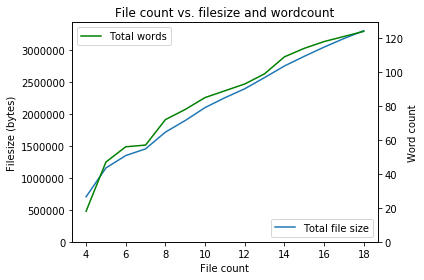

In [220]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
line, = ax.plot(sizes.index, sizes['total_size'])
line.set_label('Total file size')
line, = ax2.plot(sizes.index, sizes['total_words'], 'g')
line.set_label('Total words')
ax2.set_ylabel("Word count")
ax.set_ylabel("Filesize (bytes)")
ax.set_xlabel("File count")
ax.legend(loc='lower right')
ax2.legend(loc='upper left')
ax.set_title("File count vs. filesize and wordcount")
ax.set_ybound(lower=0)
ax2.set_ybound(lower=0)
fig.tight_layout()
fig.savefig("file_count_vs_filesize_with_wordcount.png")

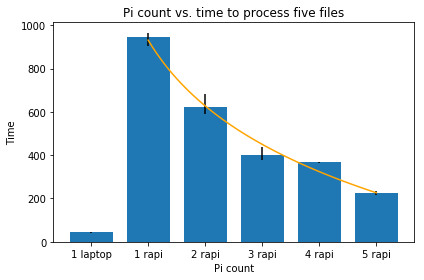

In [213]:
dat = data.query('file_count == 5').copy()
mod = smf.ols(formula='time ~ np.log(pi_count)', data=dat.query('host == "rapi"'))
res = mod.fit()

fig, ax = plt.subplots()
#dat['hostcount'] = dat['pi_count'].apply(lambda x: str(x)+' ') + dat['host']
grp = dat.groupby(['pi_count', 'host'])
names = [' '.join(str(i) for i in x) for x, _ in grp]
#bars = ax.bar(names, grp['time'].mean(), yerr=grp['time'].std()*2)
mean = grp['time'].mean()
#ax.plot(dat['pi_count'], dat['time'], "og")
error = [mean-grp['time'].min(),grp['time'].max()-mean]
ax.bar(names, mean, 0.75, yerr=error)
ax.set_ylim(bottom=0)
ax.set_xlabel('Pi count')
ax.set_ylabel('Time')
ax.set_title("Pi count vs. time to process five files")
#ax.text(3, 800, "Note: Error bars are two\nstd. dev. from mean.")
xs = np.linspace(1,5)
ys = res.predict({"pi_count":xs, "host":"rapi"})
ax.plot(xs, ys, 'orange')
fig.tight_layout()
fig.savefig("pi_count_vs_time_five_files.png")

In [154]:
laptop_time = data.query('host == "laptop" & file_count == 5')['time'].mean()
def pi_count_from_time(time):
    return np.exp((time-res.params['Intercept'])/res.params['np.log(pi_count)'])
print(pi_count_from_time(laptop_time))
print(laptop_time)
print(data.query('host == "laptop"'))

7.597361745321895
43.043888648351036
   file_count  pi_count       time     timestamp    host  pitime_per_file
0           5         1  42.665680  1.521741e+09  laptop         8.533136
1           5         1  42.892954  1.521741e+09  laptop         8.578591
2           5         1  43.503964  1.521741e+09  laptop         8.700793
3           5         1  43.151668  1.521741e+09  laptop         8.630334
4           5         1  43.061880  1.521741e+09  laptop         8.612376
5           5         1  42.987186  1.521741e+09  laptop         8.597437
6           6         1  65.870512  1.521749e+09  laptop        10.978419
7           6         1  63.586253  1.521749e+09  laptop        10.597709
8           6         1  64.562884  1.521749e+09  laptop        10.760481


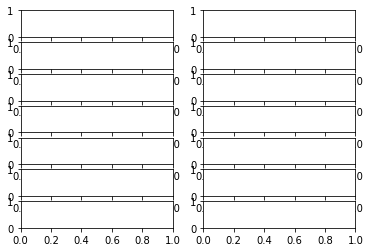

In [8]:
groups = data.groupby('file_count')
fig, ax = plt.subplots(7,2)
#ax.apply(lambda x: x.set_frame_on(False))
for i, (count, grp) in enumerate(groups):
    #ax[i//2, i%2].set_frame_on(False)
    pass
#sns.stripplot(x='pi_count', y='pitime_per_file', hue='host', data=data, ax=ax)
#ax.set_ylim(bottom=0)
#fig.savefig("pitime_per_file_vs_count.png")

In [ ]:
onejump = data['pi_count'].apply(lambda x: x in [1,2,5])

In [ ]:
data.loc[onejump]['pitime_per_file'].mean()

In [ ]:
curve_up = data['pi_count'].apply(lambda x: x in [2,3,4])
count_mod = smf.ols(formula='pitime_per_file ~ pi_count', data=data.loc[curve_up])
count_res = count_mod.fit()
count_res.summary()

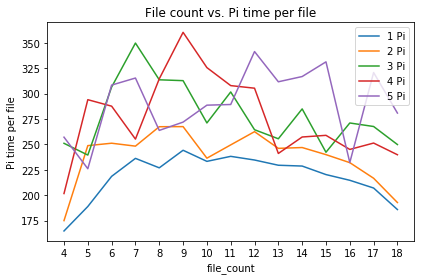

In [218]:
fig, ax = plt.subplots()
pidata = data.query('host == "rapi"')
for count, grp in pidata.groupby('pi_count'):
    grp = grp.groupby('file_count').mean()
    line, = ax.plot(grp.index, grp['pitime_per_file'], '-')
    line.set_label(str(count) + " Pi")
ax.set_xlabel("file_count")
ax.set_ylabel("Pi time per file")
ax.set_title("File count vs. Pi time per file")
ax.set_xticks(pidata['file_count'].unique())
ax.legend()
#ax.set_ylim(bottom=0)
fig.tight_layout()
fig.savefig('file_count_vs_pitime_per_file.png')

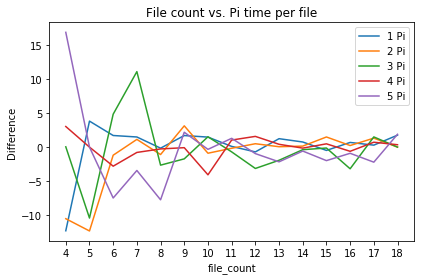

In [216]:
fig, ax = plt.subplots()
pidata = data.loc[data['host'] == 'rapi']
for count, grp in pidata.groupby('pi_count'):
    grp = grp.groupby('file_count')
    median = grp.median()
    mean = grp.mean()
    diff = median-mean
    line, = ax.plot(diff.index, diff['pitime_per_file'], '-')
    line.set_label(str(count) + " Pi")
ax.set_xlabel("file_count")
ax.set_ylabel("Difference")
ax.set_title("File count vs. Pi time per file")
ax.set_xticks(pidata['file_count'].unique())
ax.legend()
fig.tight_layout()
#fig.savefig('file_count_vs_pitime_per_file.png')

/home/andrew/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3245: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


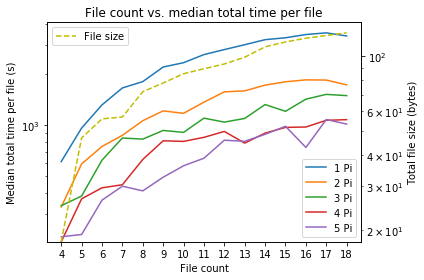

In [219]:
fig, ax = plt.subplots()
pidata = data.query('host == "rapi"')
for count, grp in pidata.groupby('pi_count'):
    grp = grp.groupby('file_count').median()
    line, = ax.plot(grp.index, grp['time'], '-')
    line.set_label(str(count) + " Pi")
ax2 = ax.twinx()
ax2.set_ylabel("Total file size (bytes)")
line, = ax2.plot(sizes['number'], sizes['total_words'], '--y')
line.set_label("File size")
ax2.legend(loc='upper left')
ax.set_xlabel("File count")
ax.set_ylabel("Median total time per file (s)")
ax.set_yscale('log')
ax2.set_yscale('log')
ax.set_title("File count vs. median total time per file")
ax.set_xticks(pidata['file_count'].unique())
ax.legend()
ax.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)
fig.tight_layout()
fig.savefig('file_count_vs_median_total_time_per_file_with_file_size.png')
# Add more axis numbers on y-axes

In [ ]:
sizes['total_words']
data.query('host=="rapi" & pi_count==1').groupby('file_count').mean()